In [4]:
!pip install pymssql

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import pandas as pd
import numpy as np
%matplotlib inline

In [5]:
import regex as re
import datetime
import time
import os
import json
import warnings
warnings.filterwarnings('ignore')
import sys
import sqlalchemy
import cx_Oracle
import pymssql
import pyodbc
import multiprocessing as mp

### 1. Load Data

In [3]:
#Open connection to DWH
#PREPARE CORRECT QUERY WITH ALL NEEDED COLUMNS


In [3]:
host=''
port=
sname=''
user=''
password=''
conn=cx_Oracle.connect('{}/{}@{}:{}/{}'.format(user,password,host,str(port),sname))
cur = conn.cursor()
query_select="""\
select
*
from AD_TOIDP_TMP_ALL_02
where PRODUCT_CDE like '%--1003%'
"""

#offset 0 rows fetch next 4000001 rows only


In [4]:
cur.execute(query_select)

<cx_Oracle.Cursor on <cx_Oracle.Connection to DW_ANALYTICS@192.168.124.105:1594/DWDEV>>

In [5]:
# Create dataframe
col_names = []
for i in range (0,len(cur.description)):
    col_names.append(cur.description[i][0])
df_dp = pd.DataFrame(cur.fetchall(),columns = col_names)
cur.close()
conn.close()

In [7]:
df_dp.isnull().sum()

CUSTOMER_CDE         0
PRODUCT_CDE          0
ACCT_ID              0
AMT_INIT             0
AMT_CUR              0
INTEREST_RATE    76892
RATE_FTP             0
SUB_TERM_ID          0
LMV                  0
LBV                  0
ACCT_USE_DAYS        0
TOI                  0
PROCESS_MONTH        0
PROCESS_YEAR         0
dtype: int64

In [13]:
len(df_dp)

674841

In [14]:
df_dp.drop(df_dp[df_dp.INTEREST_RATE.isnull()==True].index,inplace=True)

In [15]:
len(df_dp)

674841

In [10]:
# df_dp["INTEREST_RATE_END"].fillna(df_dp["INTEREST_RATE_START"], inplace = True)

### 4. Exploration Data Analysis

In [16]:
numerical_columns=['AMT_INIT','AMT_CUR',
       'ACCT_USE_DAYS', 'INTEREST_RATE',
       'RATE_FTP', 'TOI']

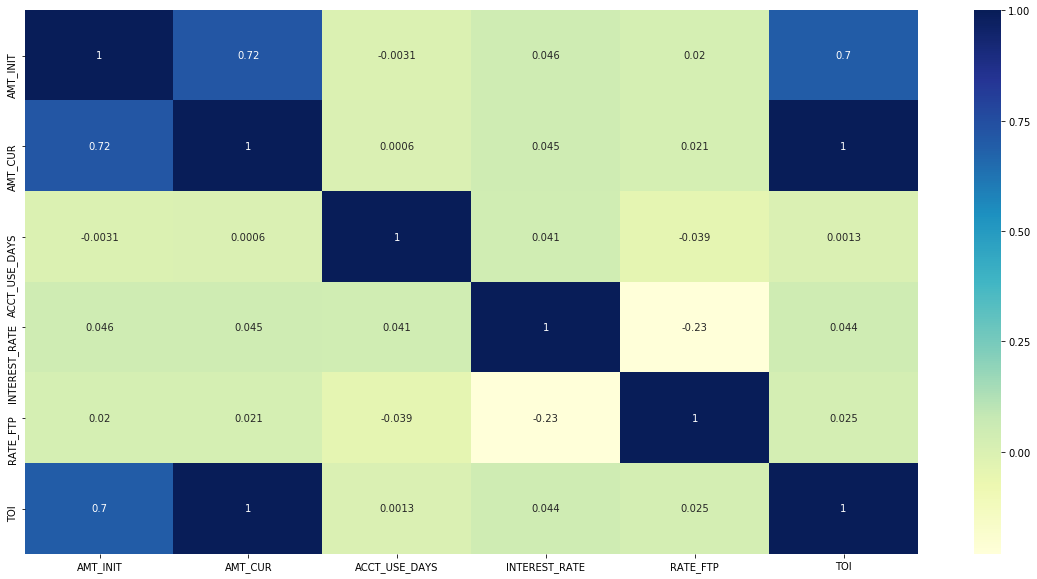

In [17]:
# Let's see the correlation between different variables.
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df_dp[numerical_columns]. corr(), cmap="YlGnBu", annot = True)
plt.show()

In [22]:
df_dp.groupby('PRODUCT_CDE')['PRODUCT_CDE'].count().reset_index(name='count').sort_values(['count'],ascending=False)

,PRODUCT_CDE,count
10,11011--1003,161365
13,11032--1003,152390
3,10015--1003,49076
0,-1--1003,27652
6,10073--1003,4978
2,10013--1003,4140
7,10075--1003,2853
8,10079--1003,1173
4,10020--1003,418
5,10032--1003,52


In [19]:
col_label = ['AMT_CUR','ACCT_USE_DAYS','INTEREST_RATE','RATE_FTP','TOI']

In [20]:
df_dp.drop_duplicates(subset=col_label, inplace=True)
df_dp = df_dp.reset_index(drop=True)

In [27]:
len(df_dp)

403279

In [23]:
df_dp = df_dp.reset_index(drop=True)

In [26]:
df_dp.drop(df_dp[df_dp['TOI']<=1].index,inplace=True)

In [29]:
df_dp['TOI_LOG'] = pd.to_numeric(np.log(df_dp['TOI']), errors='coerce')

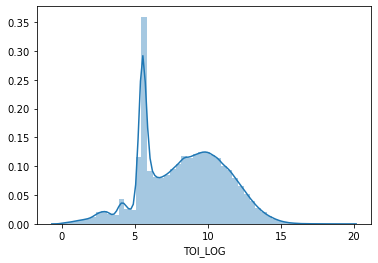

In [30]:
sns.distplot(df_dp['TOI_LOG'])

In [31]:
df_dp['AMT_CUR_LOG'] = pd.to_numeric(np.log(df_dp['AMT_CUR']), errors='coerce')

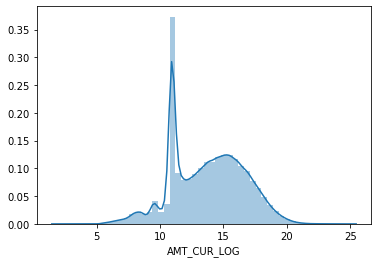

In [32]:
sns.distplot(df_dp['AMT_CUR_LOG'])

In [36]:
numerical_columns2=['AMT_CUR_LOG','ACCT_USE_DAYS','INTEREST_RATE','RATE_FTP','TOI_LOG']

In [37]:
df_dp[numerical_columns2].head()

,AMT_CUR_LOG,ACCT_USE_DAYS,INTEREST_RATE,RATE_FTP,TOI_LOG
0,9.472705,31,0.3,5.4,4.088023
1,10.902593,31,0.3,5.4,5.517911
2,10.992655,31,0.3,5.4,5.607974
3,9.210340,31,0.3,5.4,3.825659
4,16.548959,31,0.3,5.4,11.107119


### 5. Normalization

In [38]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

#### EDA

In [51]:
PRODUCT_CDE_df = pd.get_dummies(df_dp['PRODUCT_CDE'], prefix = 'PRODUCT')

In [52]:
PRODUCT_CDE_df.head()

,PRODUCT_-1--1003,PRODUCT_10011--1003,PRODUCT_10013--1003,PRODUCT_10015--1003,PRODUCT_10020--1003,PRODUCT_10032--1003,PRODUCT_10073--1003,PRODUCT_10075--1003,PRODUCT_10079--1003,PRODUCT_10100--1003,PRODUCT_11011--1003,PRODUCT_11015--1003,PRODUCT_11026--1003,PRODUCT_11032--1003
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
PRODUCT_CDE_df.columns

Index(['PRODUCT_-1--1003', 'PRODUCT_10011--1003', 'PRODUCT_10013--1003',
       'PRODUCT_10015--1003', 'PRODUCT_10020--1003', 'PRODUCT_10032--1003',
       'PRODUCT_10073--1003', 'PRODUCT_10075--1003', 'PRODUCT_10079--1003',
       'PRODUCT_10100--1003', 'PRODUCT_11011--1003', 'PRODUCT_11015--1003',
       'PRODUCT_11026--1003', 'PRODUCT_11032--1003'],
      dtype='object')

In [62]:
a = PRODUCT_CDE_df.columns.tolist()

In [53]:
df_dp.drop(['PRODUCT_CDE'],axis=1, inplace = True)

In [56]:
df_dp.columns

Index(['CUSTOMER_CDE', 'ACCT_ID', 'AMT_INIT', 'AMT_CUR', 'INTEREST_RATE',
       'RATE_FTP', 'SUB_TERM_ID', 'LMV', 'LBV', 'ACCT_USE_DAYS', 'TOI',
       'PROCESS_MONTH', 'PROCESS_YEAR', 'TOI_LOG', 'AMT_CUR_LOG'],
      dtype='object')

In [57]:
temp = pd.concat([PRODUCT_CDE_df,df_dp], axis = 1)

In [65]:
numerical_columns2 = a + ['AMT_CUR_LOG','ACCT_USE_DAYS','INTEREST_RATE','RATE_FTP']

In [68]:
robust=RobustScaler()
s_rb=robust.fit_transform(temp[numerical_columns2])

In [69]:
df_mm = pd.DataFrame(s_rb, columns=numerical_columns2)

In [70]:
df_mm.head()

,PRODUCT_-1--1003,PRODUCT_10011--1003,PRODUCT_10013--1003,PRODUCT_10015--1003,PRODUCT_10020--1003,PRODUCT_10032--1003,PRODUCT_10073--1003,PRODUCT_10075--1003,PRODUCT_10079--1003,PRODUCT_10100--1003,PRODUCT_11011--1003,PRODUCT_11015--1003,PRODUCT_11026--1003,PRODUCT_11032--1003,AMT_CUR_LOG,ACCT_USE_DAYS,INTEREST_RATE,RATE_FTP
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.908514,0.0,0.0,-1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.609172,0.0,0.0,-1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.590317,0.0,0.0,-1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.963439,0.0,0.0,-1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.572876,0.0,0.0,-1.0


In [71]:
len(df_dp)

403279

In [72]:
len(df_mm)

403279

### Training/Test Splitting

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_mm, df_dp['TOI_LOG'], test_size=0.2, random_state=42)

### Tree based model

In [74]:
from sklearn.metrics import mean_squared_error, r2_score

In [75]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred_rf = rfr.predict(X_test)


In [76]:
print(f'RMSE        = {mean_squared_error(y_test, y_pred_rf)**0.5:.4f}')
print(f'R-squared   = {r2_score(y_test, y_pred_rf):.4f}')

RMSE        = 0.0676
R-squared   = 0.9994


In [77]:
import xgboost as xgb

xgr = xgb.XGBRegressor(learning_rate=0.05,max_depth=4,n_estimators=5000)
xgr.fit(X_train, y_train)
y_pred_xgr = xgr.predict(X_test)

In [78]:
print(f'RMSE        = {mean_squared_error(y_test, y_pred_xgr)**0.5:.4f}')
print(f'R-squared   = {r2_score(y_test, y_pred_xgr):.4f}')

RMSE        = 0.0634
R-squared   = 0.9995


In [79]:
y_test = y_test.reset_index(drop=True)
y_std = abs(y_test-y_pred_xgr)
y_test_ser = pd.Series(y_test)
y_pred_xgr_ser = pd.Series(y_pred_xgr)
y_std_ser = pd.Series(y_std)
data_result2  = pd.concat([y_pred_xgr_ser, y_test_ser,y_std_ser], axis=1, keys=['TOI_DP_PREDICT', 'TOI_DP_ACTUAL','TOI_STD'])

In [80]:
data_result2 = np.exp(data_result2)

In [81]:
data_result2.head()

,TOI_DP_PREDICT,TOI_DP_ACTUAL,TOI_STD
0,90817.292794,91500.893465,1.007527
1,18964.347493,18752.649144,1.011289
2,345.068630,340.949376,1.012082
3,49845.560931,49275.144228,1.011576
4,58822.784239,58708.670941,1.001944


In [82]:
data_result2['TOI_STD']=abs(data_result2['TOI_DP_ACTUAL']-data_result2['TOI_DP_PREDICT'])

In [83]:
data_result2.sort_values(by='TOI_STD',ascending=False).head(20)

,TOI_DP_PREDICT,TOI_DP_ACTUAL,TOI_STD
55061,1.213678e+08,1.244869e+08,3.119081e+06
2497,3.627202e+07,3.863261e+07,2.360595e+06
4277,5.408887e+07,5.619868e+07,2.109810e+06
57015,3.026729e+07,2.849106e+07,1.776238e+06
70343,2.674770e+07,2.509556e+07,1.652149e+06
25118,2.916234e+07,2.761614e+07,1.546199e+06
5463,2.367127e+07,2.220475e+07,1.466519e+06
65344,6.138982e+07,6.007897e+07,1.310842e+06
10881,6.192313e+07,6.069496e+07,1.228168e+06
41864,1.522878e+06,2.728965e+06,1.206086e+06


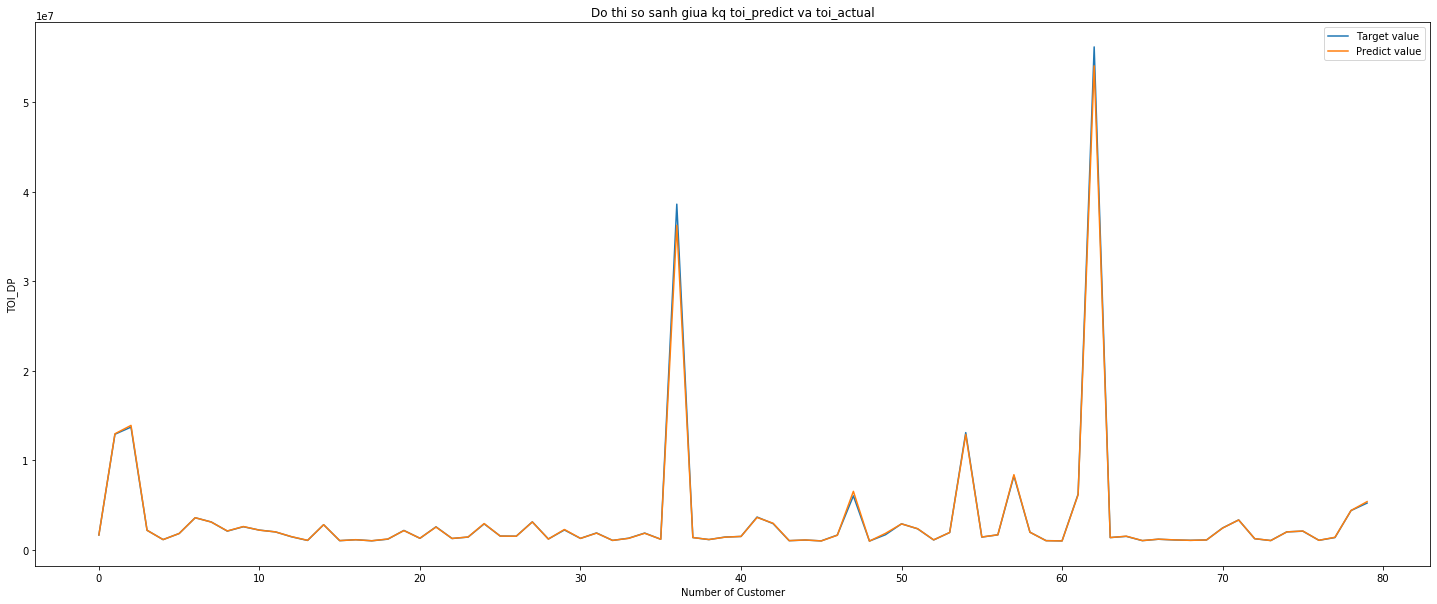

In [84]:
#Generate plot 
fig, ax = plt.subplots(figsize=(25,10))
neighbors = np.arange(0,80)
plt.title('Do thi so sanh giua kq toi_predict va toi_actual') 
plt.plot(neighbors, data_result2[(data_result2['TOI_DP_ACTUAL']>1000000)]['TOI_DP_ACTUAL'][0:80], label='Target value') 
plt.plot(neighbors, data_result2[(data_result2['TOI_DP_ACTUAL']>1000000)]['TOI_DP_PREDICT'][0:80], label='Predict value') 
plt.legend() 
plt.xlabel('Number of Customer') 
plt.ylabel('TOI_DP') 
plt.show()

[9.99686044e-01 2.28715178e-04 4.05833452e-05 4.46574899e-05]


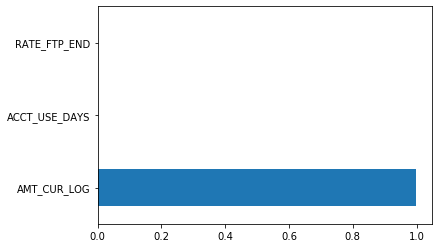

In [41]:
print(xgr.feature_importances_) #use inbuilt class feature_importances of tree based regressor
#plot graph of feature importances for better visualization
feat_importances = pd.Series(xgr.feature_importances_, index=input_col)
feat_importances.nlargest(3).plot(kind='barh')
plt.show()

In [42]:
# udfs ----

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [43]:
base_imp = imp_df(input_col, xgr.feature_importances_)
base_imp

,feature,feature_importance
0,AMT_CUR_LOG,0.999686
1,ACCT_USE_DAYS,0.000229
2,RATE_FTP_END,0.000045
3,INTEREST_RATE_END,0.000041


In [85]:
from sklearn.externals import joblib
# Save the model as a pickle in a file  
joblib.dump(xgr, 'xgr_toidp_group01.pkl')

D:\Soft\Setup_UAT_DA\Winpython64-3.7.4.1\WPy64-3741\python-3.7.4.amd64\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['xgr_toidp_group01.pkl']

In [86]:
joblib.dump(robust, 'xgr_toidp_group01_scaler_rb.pkl')

['xgr_toidp_group01_scaler_rb.pkl']

### TEST DATA 2020

In [1]:
import xgboost as xgb

In [1]:
from sklearn.externals import joblib
model_load = joblib.load('xgr_toidp_group01.pkl') 
scaler_rb_load = joblib.load('xgr_toidp_group01_scaler_rb.pkl')

In [8]:
path = r'D:\COURSE_DS_2020\KHTN_DSCOURSE\Do an cuoi ky\Data Science\01July2020\inference_toidp_group01' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_test = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_test)

df_test = pd.concat(li, axis=0, ignore_index=True)

In [9]:
df_test.isnull().sum()

CUSTOMER_CDE         0
PRODUCT_CDE          0
ACCT_ID              0
AMT_INIT             0
AMT_CUR              0
INTEREST_RATE_END    0
RATE_FTP_END         0
LMV                  0
LBV                  0
ACCT_USE_DAYS        0
TOI                  0
PROCESS_MONTH        0
PROCESS_YEAR         0
dtype: int64

In [10]:
df_test[df_test['AMT_CUR']<=1].count()

CUSTOMER_CDE         2
PRODUCT_CDE          2
ACCT_ID              2
AMT_INIT             2
AMT_CUR              2
INTEREST_RATE_END    2
RATE_FTP_END         2
LMV                  2
LBV                  2
ACCT_USE_DAYS        2
TOI                  2
PROCESS_MONTH        2
PROCESS_YEAR         2
dtype: int64

In [11]:
df_test.drop(df_test[df_test['AMT_CUR']<=1].index,inplace=True)

In [12]:
df_test[df_test['TOI']<=1].count()

CUSTOMER_CDE         2361
PRODUCT_CDE          2361
ACCT_ID              2361
AMT_INIT             2361
AMT_CUR              2361
INTEREST_RATE_END    2361
RATE_FTP_END         2361
LMV                  2361
LBV                  2361
ACCT_USE_DAYS        2361
TOI                  2361
PROCESS_MONTH        2361
PROCESS_YEAR         2361
dtype: int64

In [13]:
df_test.drop(df_test[df_test['TOI']<=1].index,inplace=True)

In [14]:
df_test.groupby('PRODUCT_CDE')['PRODUCT_CDE'].count().reset_index(name='count').sort_values(['count'],ascending=False)

,PRODUCT_CDE,count
11,11032--1003,33685
9,11011--1003,29440
3,10015--1003,10715
0,-1--1003,10363
6,10073--1003,4955
8,10079--1003,1708
2,10013--1003,1420
7,10075--1003,309
4,10020--1003,307
5,10032--1003,10


In [15]:
PRODUCT_CDE_df_temp = pd.get_dummies(df_test['PRODUCT_CDE'], prefix = 'PRODUCT')

In [16]:
PRODUCT_CDE_df_temp.columns

Index(['PRODUCT_-1--1003', 'PRODUCT_10011--1003', 'PRODUCT_10013--1003',
       'PRODUCT_10015--1003', 'PRODUCT_10020--1003', 'PRODUCT_10032--1003',
       'PRODUCT_10073--1003', 'PRODUCT_10075--1003', 'PRODUCT_10079--1003',
       'PRODUCT_11011--1003', 'PRODUCT_11015--1003', 'PRODUCT_11032--1003'],
      dtype='object')

In [17]:
idx = 9
PRODUCT_CDE_df_temp.insert(loc=idx,column='PRODUCT_10100--1003',value=0)

In [18]:
idx = 12
PRODUCT_CDE_df_temp.insert(loc=idx,column='PRODUCT_11026--1003',value=0)

In [19]:
# PRODUCT_CDE_df_temp.drop(['PRODUCT_10100--1003'],axis=1, inplace = True)

In [20]:
PRODUCT_CDE_df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92925 entries, 0 to 95287
Data columns (total 14 columns):
PRODUCT_-1--1003       92925 non-null uint8
PRODUCT_10011--1003    92925 non-null uint8
PRODUCT_10013--1003    92925 non-null uint8
PRODUCT_10015--1003    92925 non-null uint8
PRODUCT_10020--1003    92925 non-null uint8
PRODUCT_10032--1003    92925 non-null uint8
PRODUCT_10073--1003    92925 non-null uint8
PRODUCT_10075--1003    92925 non-null uint8
PRODUCT_10079--1003    92925 non-null uint8
PRODUCT_10100--1003    92925 non-null int64
PRODUCT_11011--1003    92925 non-null uint8
PRODUCT_11015--1003    92925 non-null uint8
PRODUCT_11026--1003    92925 non-null int64
PRODUCT_11032--1003    92925 non-null uint8
dtypes: int64(2), uint8(12)
memory usage: 3.2 MB


In [21]:
df_test.columns

Index(['CUSTOMER_CDE', 'PRODUCT_CDE', 'ACCT_ID', 'AMT_INIT', 'AMT_CUR',
       'INTEREST_RATE_END', 'RATE_FTP_END', 'LMV', 'LBV', 'ACCT_USE_DAYS',
       'TOI', 'PROCESS_MONTH', 'PROCESS_YEAR'],
      dtype='object')

In [22]:
df_test['TOI_LOG'] = pd.to_numeric(np.log(df_test['TOI']), errors='coerce')

In [23]:
df_test['AMT_CUR_LOG'] = pd.to_numeric(np.log(df_test['AMT_CUR']), errors='coerce')

In [24]:
temp2 = pd.concat([PRODUCT_CDE_df_temp,df_test], axis = 1)

In [25]:
temp2 = temp2.reset_index(drop=True)

In [26]:
b = PRODUCT_CDE_df_temp.columns.tolist()

In [27]:
numerical_columns_test = b + ['AMT_CUR_LOG','ACCT_USE_DAYS','INTEREST_RATE','RATE_FTP']

In [28]:
temp2.columns

Index(['PRODUCT_-1--1003', 'PRODUCT_10011--1003', 'PRODUCT_10013--1003',
       'PRODUCT_10015--1003', 'PRODUCT_10020--1003', 'PRODUCT_10032--1003',
       'PRODUCT_10073--1003', 'PRODUCT_10075--1003', 'PRODUCT_10079--1003',
       'PRODUCT_10100--1003', 'PRODUCT_11011--1003', 'PRODUCT_11015--1003',
       'PRODUCT_11026--1003', 'PRODUCT_11032--1003', 'CUSTOMER_CDE',
       'PRODUCT_CDE', 'ACCT_ID', 'AMT_INIT', 'AMT_CUR', 'INTEREST_RATE_END',
       'RATE_FTP_END', 'LMV', 'LBV', 'ACCT_USE_DAYS', 'TOI', 'PROCESS_MONTH',
       'PROCESS_YEAR', 'TOI_LOG', 'AMT_CUR_LOG'],
      dtype='object')

In [39]:
temp2.columns = ['PRODUCT_-1--1003', 'PRODUCT_10011--1003', 'PRODUCT_10013--1003',
       'PRODUCT_10015--1003', 'PRODUCT_10020--1003', 'PRODUCT_10032--1003',
       'PRODUCT_10073--1003', 'PRODUCT_10075--1003', 'PRODUCT_10079--1003',
       'PRODUCT_10100--1003', 'PRODUCT_11011--1003', 'PRODUCT_11015--1003',
       'PRODUCT_11026--1003', 'PRODUCT_11032--1003', 'CUSTOMER_CDE',
       'PRODUCT_CDE', 'ACCT_ID', 'AMT_INIT', 'AMT_CUR', 'INTEREST_RATE',
       'RATE_FTP', 'LMV', 'LBV', 'ACCT_USE_DAYS', 'TOI', 'PROCESS_MONTH',
       'PROCESS_YEAR', 'TOI_LOG', 'AMT_CUR_LOG']

In [41]:
s_rb_test=scaler_rb_load.transform(temp2[numerical_columns_test])

In [42]:
df_mm_test = pd.DataFrame(s_rb_test, columns=numerical_columns_test)

In [43]:
len(df_mm_test)

92925

In [44]:
len(temp2)

92925

In [45]:
df_mm_test.head()

,PRODUCT_-1--1003,PRODUCT_10011--1003,PRODUCT_10013--1003,PRODUCT_10015--1003,PRODUCT_10020--1003,PRODUCT_10032--1003,PRODUCT_10073--1003,PRODUCT_10075--1003,PRODUCT_10079--1003,PRODUCT_10100--1003,PRODUCT_11011--1003,PRODUCT_11015--1003,PRODUCT_11026--1003,PRODUCT_11032--1003,AMT_CUR_LOG,ACCT_USE_DAYS,INTEREST_RATE,RATE_FTP
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.190674,0.0,0.000000,-1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.099310,0.0,-0.666667,-6.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.143282,-2.0,0.000000,-1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.153697,-1.0,-0.666667,-19.8
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.017123,0.0,0.000000,-1.0


In [46]:
y_pred_xgr = model_load.predict(df_mm_test)

In [50]:
y_test = temp2['TOI']

In [54]:
y_pred_xgr = np.exp(y_pred_xgr)

In [52]:
from sklearn.metrics import mean_squared_error, r2_score

In [55]:
print(f'RMSE        = {mean_squared_error(y_test, y_pred_xgr)**0.5:.4f}')
print(f'R-squared   = {r2_score(y_test, y_pred_xgr):.4f}')

RMSE        = 41635.2377
R-squared   = 0.9958


In [56]:
y_test = y_test.reset_index(drop=True)
y_std = abs(y_test-y_pred_xgr)
y_test_ser = pd.Series(y_test)
y_pred_xgr_ser = pd.Series(y_pred_xgr)
y_std_ser = pd.Series(y_std)
data_result2  = pd.concat([y_pred_xgr_ser, y_test_ser,y_std_ser], axis=1, keys=['TOI_DP_PREDICT', 'TOI_DP_ACTUAL','TOI_STD'])

In [80]:
# data_result2 = np.exp(data_result2)

In [57]:
data_result2.head()

,TOI_DP_PREDICT,TOI_DP_ACTUAL,TOI_STD
0,1826.198242,1778.688011,47.510231
1,3243.127197,2730.484949,512.642248
2,2190.770264,2100.395773,90.374491
3,9.311487,11.715712,2.404225
4,36.725849,35.489099,1.236750


In [58]:
data_result2['TOI_STD']=abs(data_result2['TOI_DP_ACTUAL']-data_result2['TOI_DP_PREDICT'])

In [59]:
data_result2.sort_values(by='TOI_STD',ascending=False).head(20)

,TOI_DP_PREDICT,TOI_DP_ACTUAL,TOI_STD
50915,82344272.0,8.827117e+07,5.926896e+06
23228,76679848.0,8.259035e+07,5.910504e+06
23227,69252800.0,6.549140e+07,3.761399e+06
12803,17759996.0,1.458632e+07,3.173678e+06
4750,17949616.0,1.519101e+07,2.758601e+06
45838,31302384.0,2.899035e+07,2.312039e+06
13021,18584258.0,1.636399e+07,2.220270e+06
46218,62184584.0,6.034473e+07,1.839849e+06
12802,17379188.0,1.556531e+07,1.813881e+06
24572,17954752.0,1.625010e+07,1.704655e+06


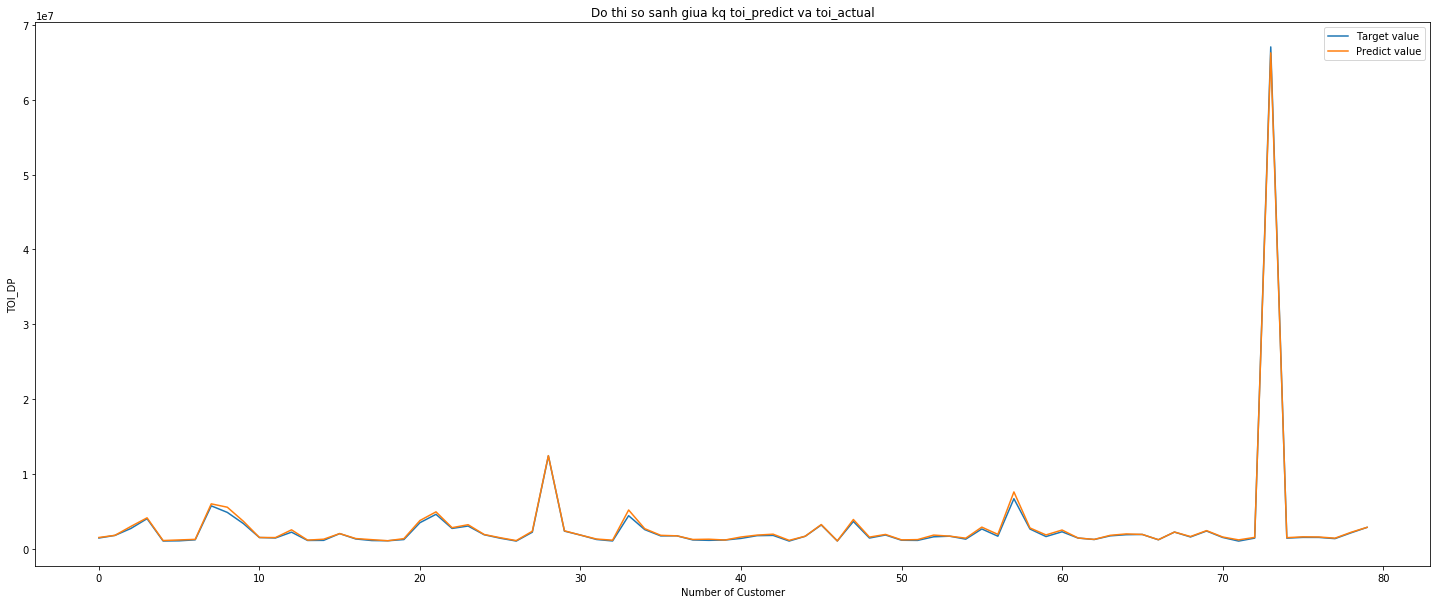

In [60]:
#Generate plot 
fig, ax = plt.subplots(figsize=(25,10))
neighbors = np.arange(0,80)
plt.title('Do thi so sanh giua kq toi_predict va toi_actual') 
plt.plot(neighbors, data_result2[(data_result2['TOI_DP_ACTUAL']>1000000)]['TOI_DP_ACTUAL'][0:80], label='Target value') 
plt.plot(neighbors, data_result2[(data_result2['TOI_DP_ACTUAL']>1000000)]['TOI_DP_PREDICT'][0:80], label='Predict value') 
plt.legend() 
plt.xlabel('Number of Customer') 
plt.ylabel('TOI_DP') 
plt.show()